<a href="https://colab.research.google.com/github/olgOk/Adaptive_QNG/blob/main/H_LiH_TIFModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!python3 -m pip install -q qiskit
!python3 -m pip install -q matplotlib
!python3 -m pip install -q qiskit-nature
!python3 -m pip install -q qiskit-nature-pyscf -U

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pylab

from qiskit import Aer
from qiskit.opflow import X, Z, I
from qiskit.utils import QuantumInstance, algorithm_globals
from qiskit.algorithms import VQE, NumPyMinimumEigensolver
from qiskit.algorithms.optimizers import COBYLA, L_BFGS_B, SLSQP
from qiskit.circuit.library import TwoLocal

# Ground State: H Molecule

In [3]:
from qiskit.algorithms.optimizers import GradientDescent


def learning_rate():
  """
    Define the learning rate.
    Args: 
      None.
    Returns:
      power
  """
  power = 0.4
  constant_coeff = 0.1
  def powerlaw():
      n = 0
      while True:
        yield constant_coeff * (n ** power)
        n += 1

  return powerlaw()

def f(x):
  """
  """
  return np.cos(x[0])**2*np.sin(x[1])**2 + np.cos(x[0])**2*np.sin(x[1])**2

# define the initial point 
initial_point = np.array([1, 0.5])

# use a custom learning rate function
optimizer_custom = GradientDescent(maxiter=40, learning_rate=learning_rate)

result = optimizer_custom.minimize(fun=f, x0=initial_point)

print(f"Found minimum {result.x} at a value of {result.fun} using {result.nfev} evaluations.")

Found minimum [ 1.28419458e+00 -8.85993935e-04] at a value of 1.2546576894113442e-07 using 120 evaluations.


Construct the contour plot of the Hydrogen Hamiltonian.

/usr/local/lib/python3.8/dist-packages/mpl_toolkits/mplot3d/art3d.py:304: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  self._segments3d = np.asanyarray(segments)


Text(0.5, 0, 'P')

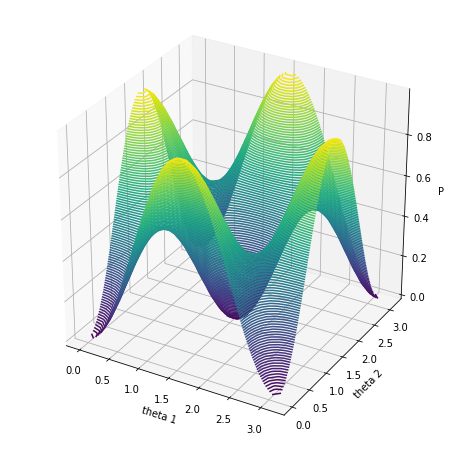

In [4]:
theta1 = np.linspace(0, np.pi, 30)
theta2 = np.linspace(0, np.pi, 30)

def RyTransitionProbability(theta1,theta2):
  z = np.empty((len(theta1),len(theta2)))
  for i in range(len(theta1)):
    for j in range(len(theta2)):
      z[i,j] = np.cos(theta1[i])**2*np.sin(theta2[j])**2 + np.cos(theta2[j])**2*np.sin(theta1[i])**2
  return z

z = RyTransitionProbability(theta1,theta2)

fig = plt.figure(figsize=(8,8))
ax = plt.axes(projection='3d')
ax.contour3D(theta1, theta2, z, 100, cmap='viridis')
ax.set_xlabel('theta 1')
ax.set_ylabel('theta 2')
ax.set_zlabel('P')

Evaluating QNGD optimizers with varying hyperparms on $H_2$:

In [5]:
#TODO: Implement using quantum chemistry library
H2_op = (-1.052373245772859 * I ^ I) + \
        (0.39793742484318045 * I ^ Z) + \
        (-0.39793742484318045 * Z ^ I) + \
        (-0.01128010425623538 * Z ^ Z) + \
        (0.18093119978423156 * X ^ X)
print(type(H2_op))

<class 'qiskit.opflow.primitive_ops.pauli_sum_op.PauliSumOp'>


QNGD class using Qiskit GradientDescent object. This learning rate function causes the step sizes to decrease over time.

In [6]:
class QNGD(GradientDescent):

  def  __init__(self, power, constant_coeff):
    self.power = power
    self.constant_coeff = constant_coeff
    GradientDescent.__init__(self, maxiter=30, learning_rate=self.learning_rate)

  def learning_rate(self):
    def powerlaw():
        n = 0
        while True:
          yield self.constant_coeff * (n ** self.power)
          n += 1

    return powerlaw()

    def run(self, f, initial_point):
        result = self.minimize(fun=f, x0=initial_point)
        print(f"Found minimum {result.x} at a value of {result.fun} using {result.nfev} evaluations.")
        return result

## Experiement 1: Comparing accuracy of Qiskit Gradient Decent on using different powers. 

Larger powers take bigger steps over the evaluations, ie. model converges faster.

In [7]:
powers = np.linspace(0.1,0.9,9)
constant = 0.1
optimizers = [QNGD(power=p, constant_coeff=constant) for p in powers]
converge_cnts = np.empty([len(optimizers)], dtype=object)
converge_vals = np.empty([len(optimizers)], dtype=object)

for i, optimizer in enumerate(optimizers):
    print('\rOptimizer: {}        '.format(type(optimizer).__name__), end='')
    algorithm_globals.random_seed = 50
    ansatz = TwoLocal(rotation_blocks='ry', entanglement_blocks='cz')

    counts = []
    values = []
    def store_intermediate_result(eval_count, parameters, mean, std):
        counts.append(eval_count)
        values.append(mean)

    vqe = VQE(ansatz, optimizer, callback=store_intermediate_result,
              quantum_instance=QuantumInstance(backend=Aer.get_backend('statevector_simulator')))
    result = vqe.compute_minimum_eigenvalue(operator=H2_op)
    converge_cnts[i] = np.asarray(counts)
    converge_vals[i] = np.asarray(values)
print('\rOptimization complete      ')



Optimization complete      


Plot Results

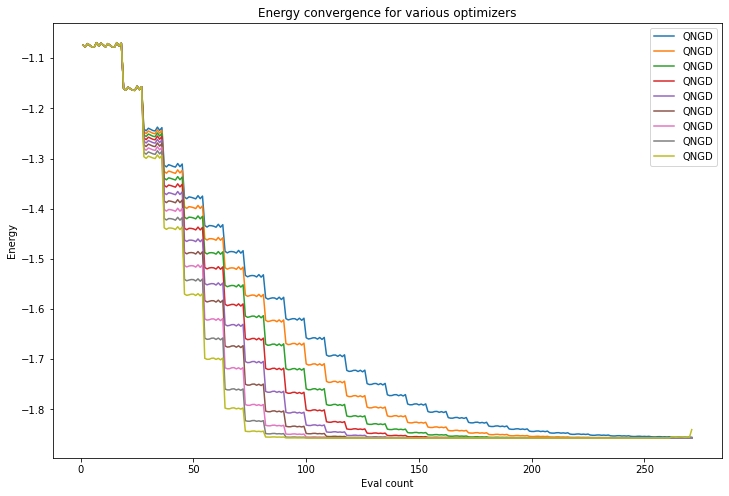

In [8]:
pylab.rcParams['figure.figsize'] = (12, 8)
for i, optimizer in enumerate(optimizers):
    pylab.plot(converge_cnts[i], converge_vals[i], label=type(optimizer).__name__)
pylab.xlabel('Eval count')
pylab.ylabel('Energy')
pylab.title('Energy convergence for various optimizers')
pylab.legend(loc='upper right')

Compare with the NumPyMinimumEigensolver.

In [9]:
npme = NumPyMinimumEigensolver()
result = npme.compute_minimum_eigenvalue(operator=H2_op)
ref_value = result.eigenvalue.real
print(f'Reference value: {ref_value:.5f}')

Reference value: -1.85728


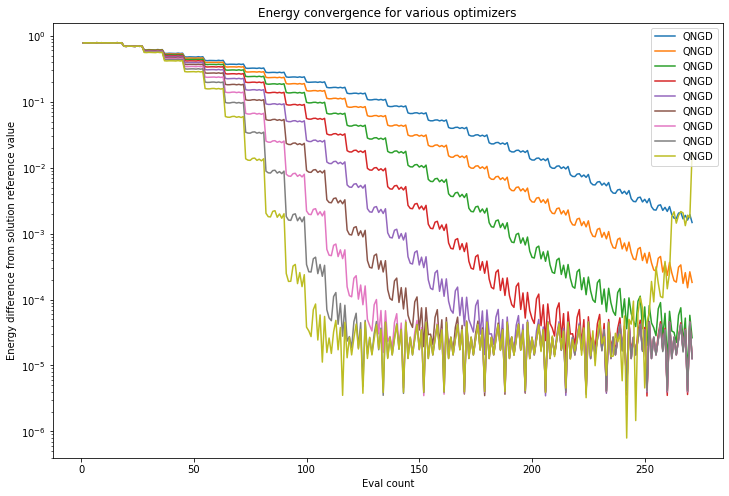

In [10]:
for i, optimizer in enumerate(optimizers):
    pylab.plot(converge_cnts[i], abs(ref_value - converge_vals[i]), label=type(optimizer).__name__)
pylab.xlabel('Eval count')
pylab.ylabel('Energy difference from solution reference value')
pylab.title('Energy convergence for various optimizers')
pylab.yscale('log')
pylab.legend(loc='upper right')

# Ground State: LiH Model

The information about molecular structure could be accessible [here](https://webbook.nist.gov/cgi/cbook.cgi?Name=LiH&Units=SI).

In [11]:
!python3 -m pip install prototype-zne --quiet

In [12]:
# Import necessary libraries and packages
import math
import matplotlib.pyplot as plt
import numpy as np

import warnings
warnings.filterwarnings('ignore')

from qiskit import Aer, IBMQ, QuantumCircuit
from qiskit.primitives import Estimator
from qiskit.providers.aer import StatevectorSimulator, QasmSimulator
from qiskit.utils import QuantumInstance

from qiskit.tools.jupyter import *
from qiskit.visualization import *

# Import Qiskit libraries for VQE
from qiskit.algorithms import MinimumEigensolverResult, VQE
from qiskit.algorithms.optimizers import SLSQP, SPSA

# Import Qiskit Nature libraries
from qiskit_nature.algorithms import GroundStateEigensolver, VQEUCCFactory
from qiskit_nature.algorithms.ground_state_solvers.minimum_eigensolver_factories import NumPyMinimumEigensolverFactory
from qiskit_nature.circuit.library import UCC, UCCSD
from qiskit_nature.drivers import Molecule
from qiskit_nature.drivers.second_quantization import ElectronicStructureDriverType, ElectronicStructureMoleculeDriver
from qiskit_nature.converters.second_quantization import QubitConverter
from qiskit_nature.mappers.second_quantization import BravyiKitaevMapper, JordanWignerMapper, ParityMapper
from qiskit_nature.problems.second_quantization.electronic import ElectronicStructureProblem
from qiskit_nature.transformers.second_quantization.electronic import ActiveSpaceTransformer

from qiskit_nature.settings import settings

# settings.dict_aux_operators = True

# Loading your IBM Quantum account(s)
# provider = IBMQ.load_account()

In [13]:
def construct_problem(geometry, charge, multiplicity, basis, num_electrons, num_molecular_orbitals, mapper_type='ParityMapper'):
    """
      Construct the model of a molecule.
      Args:
        geometry: 
        charge: 
        multiplicity: 
        basis: 
        num_electrons:
        num_molecular_orbitals:
        mapper_type:

      Returns:
        ansatz:
        qubit_op_parity:
        real_solution:
        problem_reduced:
    """

    molecule = Molecule(geometry=geometry,
                            charge=charge, 
                            multiplicity=multiplicity) 
    driver = ElectronicStructureMoleculeDriver(molecule, basis=basis, driver_type=ElectronicStructureDriverType.PYSCF) 

    # Run the preliminary quantum chemistry calculation
    properties = driver.run()

    # Set the active space
    active_space_trafo = ActiveSpaceTransformer(num_electrons=num_electrons,
                                        num_molecular_orbitals=num_molecular_orbitals) 

    # Now you can get the reduced electronic structure problem
    problem_reduced = ElectronicStructureProblem(driver, transformers=[active_space_trafo]) # ----------- Enter your code here

    # The second quantized Hamiltonian of the reduce problem
    second_q_ops_reduced = problem_reduced.second_q_ops()

    # Set the mapper to qubits
    mapper_type = mapper_type

    if mapper_type == 'ParityMapper':
        mapper = ParityMapper()
    elif mapper_type == 'JordanWignerMapper':
        mapper = JordanWignerMapper()
    elif mapper_type == 'BravyiKitaevMapper':
        mapper = BravyiKitaevMapper()

    # Set the qubit converter with two qubit reduction to reduce the computational cost 
    parity_converter = QubitConverter(mapper, two_qubit_reduction=True)# ----------- Enter your code here    

    # Compute the Hamitonian in qubit form
    qubit_op_parity = parity_converter.convert(second_q_ops_reduced.get('ElectronicEnergy'), num_particles=problem_reduced.num_particles)
   
    # Get reference solution
    vqe_factory = VQEUCCFactory(quantum_instance=StatevectorSimulator(),optimizer=SLSQP(),ansatz=UCC(excitations='sd')) 
    solver = GroundStateEigensolver(parity_converter, vqe_factory)    
    real_solution = solver.solve(problem_reduced).total_energies[0]    
    
    ansatz=vqe_factory.ansatz
    
    return ansatz, qubit_op_parity, real_solution, problem_reduced## Converting to eV unit from Hartree unit


def custom_vqe(estimator, ansatz, ops, problem_reduced, optimizer = None, initial_point=None):
    """
    Define the custom VQE.
    Args:
      estimator: an estimator of the class 'qiskit.primitives.estimator.Estimator.
      ansatz: an ansatz of the VQE run.
      ops:
      problem_reduced:
      optimizer:
      initial_point:

    Returns:
      vqe_interpret:
      job_list:
      result:
    """

    # Define convergence list
    convergence = []

    # Keep track of jobs (Do-not-modify)
    job_list = []

    def evaluate_expectation(x):
      """
      Define evaluate_expectation function.
      Args:
       x
      Returns:
        
      """
      x = list(x)

      # Define estimator run parameters
      job =  estimator.run(ansatz, ops, x).result()# ----------- Enter your code here
      results = job.values[0]
      job_list.append(job)

      # Pass results back to callback function
      return np.real(results)


    def callback(x,fx,ax,tx,nx):
      """
        Callback function to get a view on internal states and statistics of the optimizer for visualization.
        Args:
          x;
          fx:
          ax:
          tx:
          nx:
      """
      convergence.append(evaluate_expectation(fx))

    np.random.seed(10)

    # Define initial point. We shall define a random point here based on the number of parameters in our ansatz
    if initial_point is None:
        initial_point = np.random.random(ansatz.num_parameters)

    # Define optimizer and pass callback function
    if optimizer == None:
        optimizer = SPSA(maxiter=50, callback=callback)

    # Define minimize function
    result =  optimizer.minimize(evaluate_expectation, initial_point)# ----------- Enter your code here

    vqe_interpret = []
    for i in range(len(convergence)):
        sol = MinimumEigensolverResult()
        sol.eigenvalue = convergence[i]
        sol = problem_reduced.interpret(sol).total_energies[0]
        vqe_interpret.append(sol)

    return vqe_interpret, job_list, result

Plot the result.

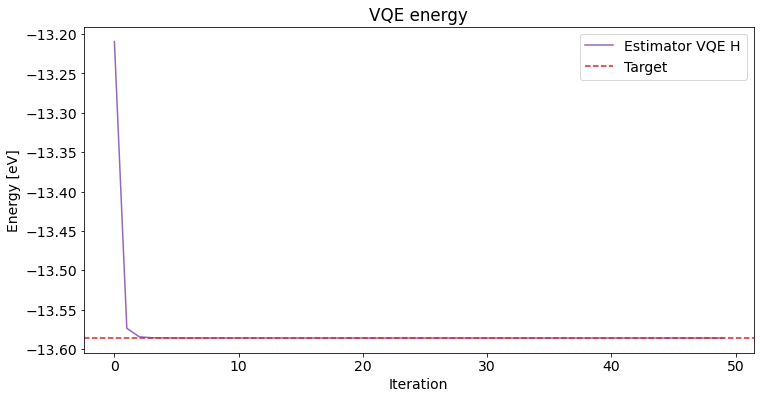

In [14]:
def plot_graph(energy, real_solution, molecule, color="tab:blue"):
    
    plt.rcParams["font.size"] = 14

    # plot loss and reference value
    plt.figure(figsize=(12, 6), facecolor='white')
    plt.plot(np.array(energy)*27.211, label="Estimator VQE {}".format(molecule),color = color) ## Converting to eV  unit from Hertree unit
    plt.axhline(y=real_solution.real*27.211, color="tab:red", ls="--", label="Target")

    plt.legend(loc="best")
    plt.xlabel("Iteration")
    plt.ylabel("Energy [eV]")
    plt.title("VQE energy")
    plt.show()


algorithm_globals.random_seed = 1024

# Constructing H
hydrogen_a = [["H",[0.0,0.0,0.0]]] 

# For H
ansatz_a, ops_a, real_solution_a, problem_reduced_a = construct_problem(geometry=hydrogen_a, charge=0, multiplicity=2, basis="ccpvdz", num_electrons=(1,0), num_molecular_orbitals=2)

# Estimator VQE for H
Energy_H_a,_,jobs = custom_vqe(estimator=Estimator(), ansatz=ansatz_a, ops=ops_a, problem_reduced=problem_reduced_a)


# Plot Graph H
plot_graph(Energy_H_a, real_solution_a, "H",color = "tab:purple")

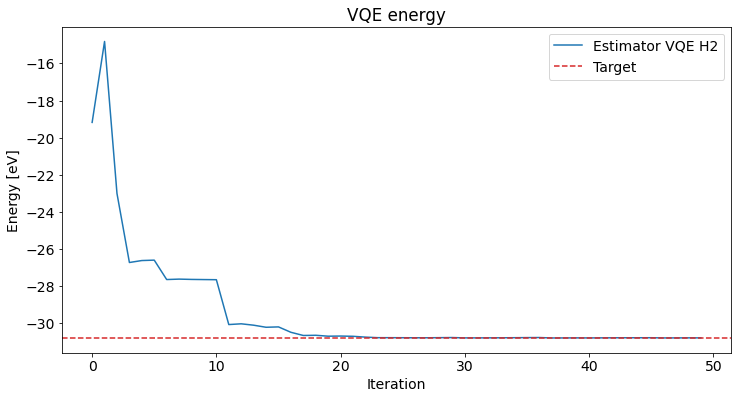

In [15]:
# Constructing H2
hydrogen_m = [["H", [0.3714,    0.0,    0.0]], 
              ["H",[ -0.3714,    0.0,   0.0]]] 

# For H2
ansatz_m, ops_m, real_solution_m, problem_reduced_m = construct_problem(geometry=hydrogen_m, charge=0, multiplicity=1, basis="ccpvdz", num_electrons=2,
                                                                        num_molecular_orbitals=2, mapper_type='JordanWignerMapper')

# Estimator VQE for H2
Energy_H_m,_,jobs = custom_vqe(estimator=Estimator(), ansatz=ansatz_m, ops=ops_m, problem_reduced=problem_reduced_m)

# Plot Graph H2
plot_graph(Energy_H_m, real_solution_m, "H2")

In [16]:
print(ops_m)

-1.1610319438813574 * IIII
+ 0.28200780250170193 * IIIZ
- 0.003861706046516318 * IIZI
+ 0.28200780250170193 * IZII
- 0.003861706046516313 * ZIII
+ 0.08210369988673774 * IIZZ
+ 0.16450096360683877 * IZIZ
+ 0.014068708230141294 * YYYY
+ 0.014068708230141294 * XXYY
+ 0.014068708230141294 * YYXX
+ 0.014068708230141294 * XXXX
+ 0.09617240811687904 * ZIIZ
+ 0.09617240811687904 * IZZI
+ 0.0836865713569141 * ZIZI
+ 0.08210369988673774 * ZZII


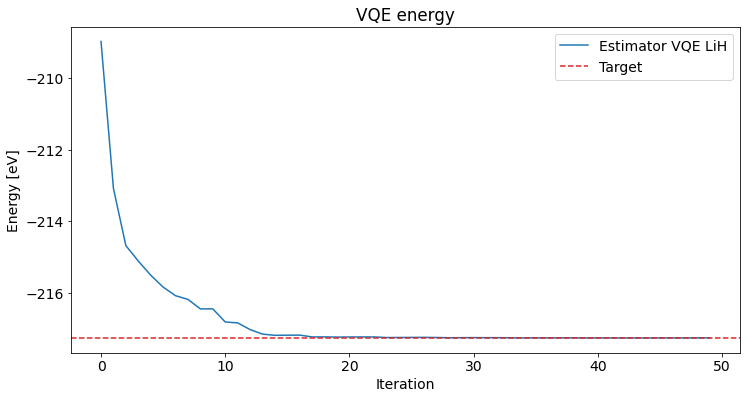

In [17]:
# Constructing LiH
Li_H = [['Li', [-0.0222,  0.0000,    0.0000]],
        ['H',    [1.5982,    0.0000,    0.0000]]]

# For LiH
ansatz_m, ops_m, real_solution_m, problem_reduced_m = construct_problem(geometry=Li_H, charge=0, multiplicity=1, basis="ccpvdz", num_electrons=2, num_molecular_orbitals=2)

# Estimator VQE for LiH
Energy_LiH_m,_,jobs = custom_vqe(estimator=Estimator(), ansatz=ansatz_m, ops=ops_m, problem_reduced=problem_reduced_m)

# Plot Graph LiH
plot_graph(Energy_LiH_m, real_solution_m, "LiH")

In [18]:
Energy_LiH_m[-1].real, real_solution_m.real ## In Hartree unit this is ground state energy of LiH

(-7.983565402790475, -7.983772106890989)

# Ground State: TIF Model

In [19]:
!python3 -m pip install pylatexenc -q

In [20]:
!python3 -m pip install qiskit_ibm_runtime -q

In [21]:
from qiskit import *
from qiskit.circuit import Parameter
from qiskit.quantum_info import Statevector, Pauli, SparsePauliOp
from qiskit.circuit.library import RealAmplitudes
import matplotlib.pyplot as plt
import matplotlib.ticker as tck
from qiskit.tools.visualization import plot_histogram
from qiskit_ibm_runtime import QiskitRuntimeService, Session, Options, Sampler, Estimator

from qiskit.utils import QuantumInstance
from qiskit.algorithms import VQE
from qiskit.algorithms.optimizers import SLSQP, GradientDescent, AQGD
from qiskit.circuit.library import TwoLocal
from qiskit.opflow.gradients import Gradient, NaturalGradient
from qiskit.opflow import X, Z, I
from qiskit.utils import algorithm_globals
import matplotlib.pyplot as plt

backend = Aer.get_backend('aer_simulator')
quantum_instance = QuantumInstance(backend=backend, shots=800, seed_simulator=99)

## Experiment 1. H Molecule with Opflow Operator

Prepare Hamiltonian using [Qiskit Opflow Operators](https://qiskit.org/documentation/apidoc/opflow.html)

$H = 0.4Z_1I_2 + 0.4I_1Z_2 + 0.2X_1X_2 = 0.4(Z_1I_2 + I_1Z_2) +  0.2X_1X_2$

## Anzatz 

Create an ansatz using Qiskit [RealAmplitude](https://qiskit.org/documentation/stubs/qiskit.circuit.library.RealAmplitudes.html) with 2 qubits and 1 repetition of rotation gates.
The total number of parameters is $2×(1+1) = 4$ (e.g. 2qubits 1 repetition)

In [22]:
H_model = (0.4 * I ^ Z) + (0.4 * Z ^ I) + (0.2 * X ^ X)

seed = 50
algorithm_globals.random_seed = seed
qi = QuantumInstance(Aer.get_backend('statevector_simulator'), seed_transpiler=seed, seed_simulator=seed)

# define ansatz as RealAmplitude as described in research paper
ansatz = RealAmplitudes(2, reps=1)

Use [AQGD (Adaptive Quantum Gradient Descent)](https://github.com/Qiskit/qiskit-terra/blob/main/qiskit/algorithms/optimizers/aqgd.py) avaliable in the qiskit.optimizers module. 

In [23]:
optimizer = AQGD(maxiter=1000)
vqe = VQE(ansatz, optimizer=optimizer, quantum_instance=qi)
result = vqe.compute_minimum_eigenvalue(H_model)
print(result)

{   'aux_operator_eigenvalues': None,
    'cost_function_evals': 234,
    'eigenstate': array([-1.22377103e-01+0.j, -5.29522800e-05+0.j, -9.46990056e-05+0.j,
        9.92483669e-01+0.j]),
    'eigenvalue': (-0.8246210505013534+0j),
    'optimal_circuit': None,
    'optimal_parameters': {   ParameterVectorElement(θ[0]): 2.6705484338423497,
                              ParameterVectorElement(θ[1]): 2.1356234787788346,
                              ParameterVectorElement(θ[2]): 0.40642989033244203,
                              ParameterVectorElement(θ[3]): 2.0849262194478078},
    'optimal_point': array([2.67054843, 2.13562348, 0.40642989, 2.08492622]),
    'optimal_value': -0.8246210505013534,
    'optimizer_evals': None,
    'optimizer_result': None,
    'optimizer_time': 0.26233363151550293}


## Experiment 2: Transverse Field Ising Model.

Fix the value of the parameter t, 𝑡=0.1, while vary the value of the parameter N, 𝑁 is in the interval [2,10].


In [24]:
t = 0.1

TFI_model = -1*(( I ^ Z ^ Z) + ( Z ^ Z ^ I)) +  t * ((I ^ I ^ X)  + (I ^ X ^ I))

In [25]:
ansatz = RealAmplitudes(3, reps=1)
optimizer = AQGD(maxiter=1000)
vqe = VQE(ansatz, optimizer=optimizer, quantum_instance=qi)
result = vqe.compute_minimum_eigenvalue(TFI_model)
print(result)

{   'aux_operator_eigenvalues': None,
    'cost_function_evals': 481,
    'eigenstate': array([-1.34716598e-03+0.j,  5.86204874e-04+0.j, -3.02574263e-05+0.j,
       -2.58541878e-05+0.j,  3.73254143e-03+0.j, -2.50070754e-02+0.j,
       -4.99209125e-02+0.j,  9.98431999e-01+0.j]),
    'eigenvalue': (-2.0075040208858406+0j),
    'optimal_circuit': None,
    'optimal_parameters': {   ParameterVectorElement(θ[1]): 1.5763277166925642,
                              ParameterVectorElement(θ[2]): -1.573734495389854,
                              ParameterVectorElement(θ[3]): 1.210968996051247,
                              ParameterVectorElement(θ[4]): -1.5229208980439424,
                              ParameterVectorElement(θ[5]): -1.5707245969502666,
                              ParameterVectorElement(θ[0]): -2.030657752942106},
    'optimal_point': array([-2.03065775,  1.57632772, -1.5737345 ,  1.210969  , -1.5229209 ,
       -1.5707246 ]),
    'optimal_value': -2.0075040208858406,
    'opti

### Setup 1. Fixed Ansatz

In [26]:
# define callback information

intermediate_info = {
    'nfev': [],
    'parameters': [],
    'energy': [],
    'stddev': []
}

def callback(nfev, parameters, energy, stddev):
    intermediate_info['nfev'].append(nfev)
    intermediate_info['parameters'].append(parameters)
    intermediate_info['energy'].append(energy)
    intermediate_info['stddev'].append(stddev)

In [27]:
from pygments.formatters import TerminalFormatter
t = 0.1

def construct_ising(N, layer_repeat):
  """
    Construct the Transverse Field Ising Model depending on the N
    Args:
      N: (int), number of the 
    Returns:
      result: the result of the Ising model construction.
  """

  TFI_model = []

  for a in range (0, N):
    ising_ham1 = ( -1 * ( (I^(N-1 - a))^( Z ^ (2)) ^ (I ^ (a))) )
    ising_ham2 =  t * (I ^ (N-a) ^ X ^ (I^(a)))
    TFI_model.append(ising_ham1)
    TFI_model.append(ising_ham2)

  TFI_model = sum(TFI_model)


  ansatz = RealAmplitudes(N+1, reps=layer_repeat)
  np.random.seed()
  initial_point = np.random.random(ansatz.num_parameters)
  optimizer = AQGD(maxiter=1000)
  vqe = VQE(ansatz=ansatz, optimizer=optimizer, initial_point=initial_point, quantum_instance=qi, callback=callback)
  result = vqe.compute_minimum_eigenvalue(TFI_model)
  # print(result)

  return result


N = [n for n in range(2, 11, 1)]
energy = []

for iter in range(2, 11, 1):
  result = construct_ising(iter, 1)
  energy.append(result.optimal_value)

energy 

[-2.007504576695577,
 -3.0100061953963686,
 -4.01250775809148,
 -5.0150093205949275,
 -6.01751088310384,
 -7.020012445608799,
 -8.022514008111381,
 -9.025015570616905,
 -10.027511095149274]

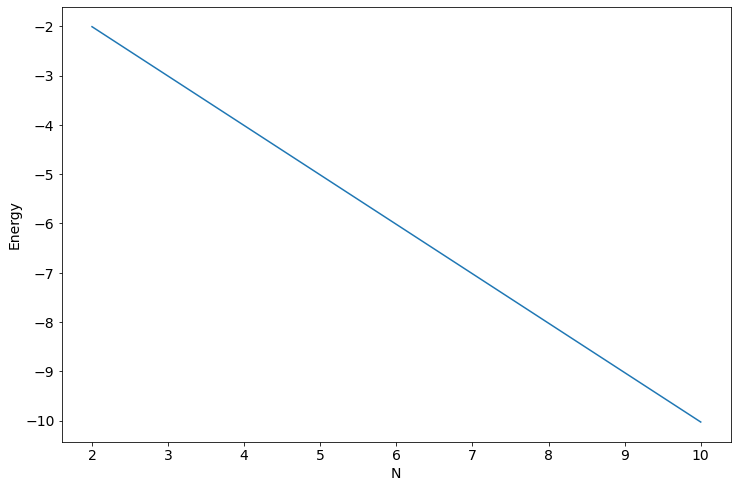

In [28]:
plt.ylabel('Energy')
plt.xlabel('N')
plt.plot(N, energy);

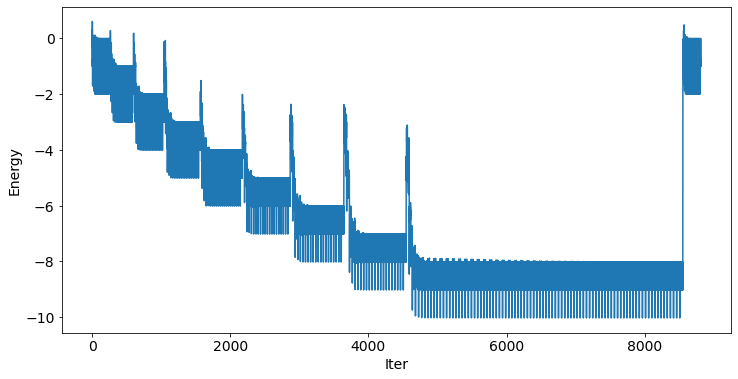

In [29]:
# change N, RealAmplitudes parameters for different experiment setup
construct_ising(2, 1)

plt.figure(figsize=(12, 6), facecolor='white')
plt.ylabel('Energy')
plt.xlabel('Iter')
plt.plot(intermediate_info['energy'])

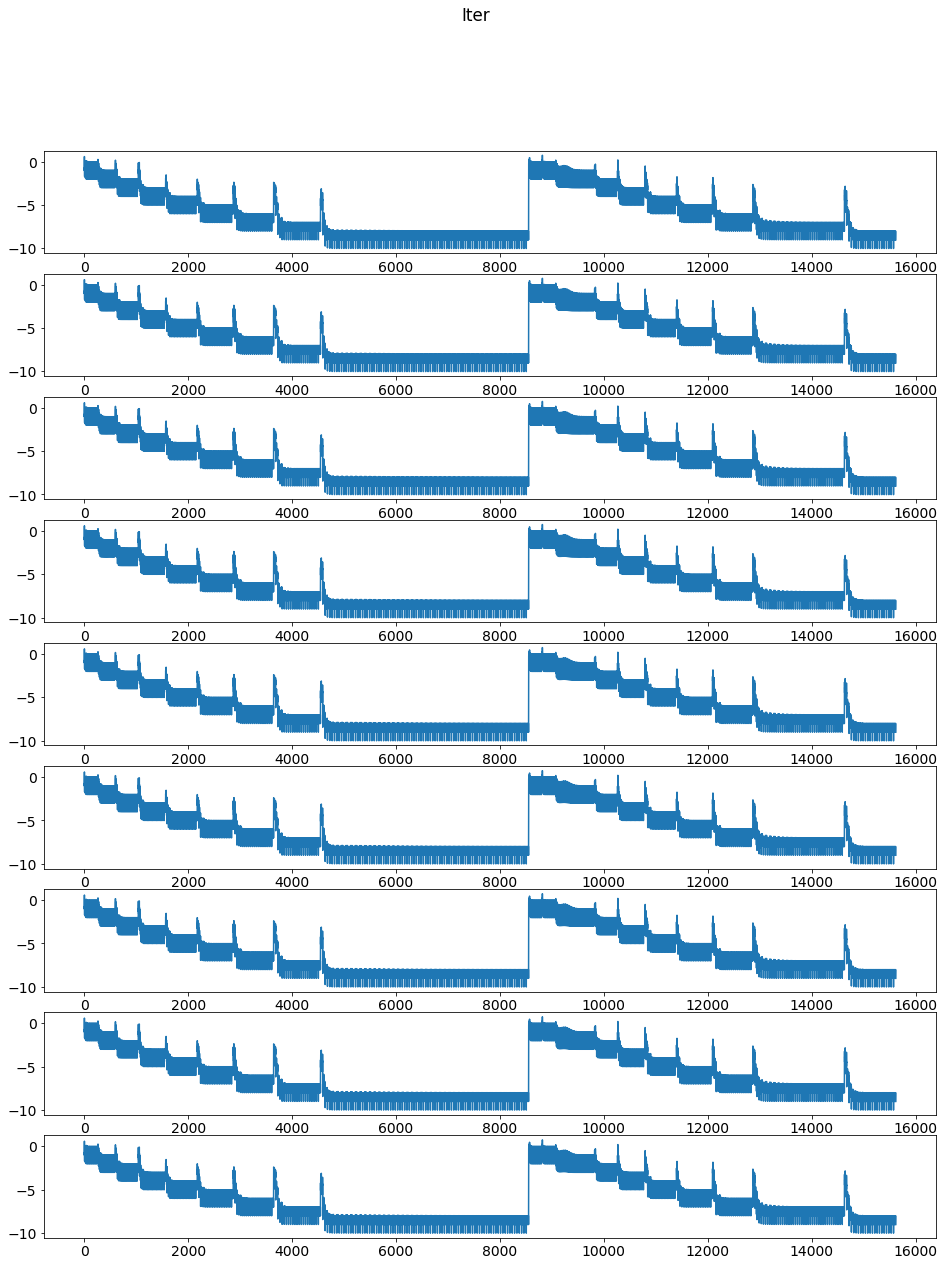

In [30]:
energy = {}

for iter in range(2, 11, 1):
  result = construct_ising(iter, 1)
  energy[iter] = intermediate_info['energy']

fig, (ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9) = plt.subplots(9, figsize=(16,20))
fig.suptitle('Iter')
ax1.plot(energy[2])
ax2.plot(energy[3])
ax3.plot(energy[4])
ax4.plot(energy[5])
ax5.plot(energy[6])
ax6.plot(energy[7])
ax7.plot(energy[8])
ax8.plot(energy[9])
ax9.plot(energy[10])

plt.show()  

### Setup 2.

The number of the parametrize layers equals the size of the problem $N$.

Example:  for $N=5$, use 5 parametrize layers and 4 entangling layers.

Note: Overparametrization may occur.

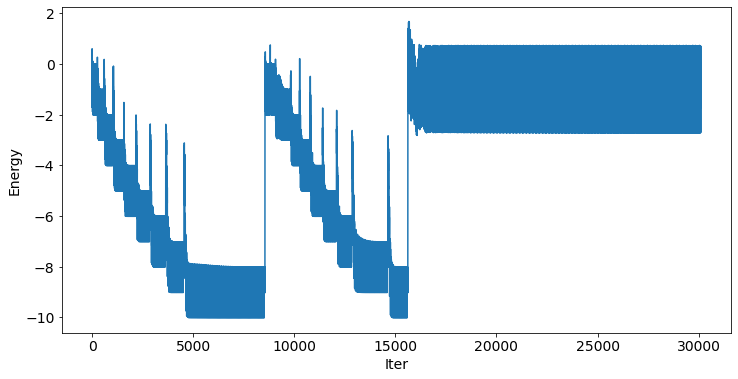

In [31]:
construct_ising(3, 3)

plt.figure(figsize=(12, 6), facecolor='white')
plt.ylabel('Energy')
plt.xlabel('Iter')
plt.plot(intermediate_info['energy'])